# Check mathematical results

Created by Louise 15-05-2023

The goal is to check mathematical results we often use, especially the ones related to spherical harmonics transforms, mean computation

We want to verify average calculation

**Potentiels problèmes:**
Avec l'ancienne version, il fallait faire attention à (voir si c'est encore valide ici):
- Qd on fait ces tests, c'est important que les cartes et alm initiaux soient créés en faisant map0 => alm => map de façon à avoir la même énergie dans la carte et dans les alm, car il peut y avoir des hautes fréquences dans les cartes non prises en compte par les alm.
- Les moyennes sur les cartes sont définies comme des moyennes et non des sommes (division par $4\pi$). Ces facteurs $4\pi$ doivent être pris en compte quand on compare des moyennes sur les $a_{\ell m}$ à celles prises sur les cartes.
- Il y a un facteur $2\sqrt{\pi}$ entre la moyenne sur $\omega$ et le terme $(\ell=0, m=0)$ de la transformée en HS, lié à la normalisation de $Y_{00}$.
- Quand on fait une moyenne sur une carte MW, il faut prendre en compte l'aire $\rm{d} \Omega = \sin\theta \rm{d}\theta \rm{d}\phi$ des éléments de surface. C'est mieux d'évaluer $\theta$ au centre de chaque pixel mais la correction est petite sauf pour les petits NSIDE (grands pixels). Ca doit être ok avec les quads...

In [2]:
from jax import jit, config

import s2fft
config.update("jax_enable_x64", True)

import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload

import s2wav
from s2wav.filter_factory.filters import filters_directional_vectorised
from s2wav.filter_factory.filters import filters_axisym_vectorised

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.plotting as plot
plot.notebook_plot_format()

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


# Make maps and flm used in the following tests on mean and variance

We will work with 3 maps: random numbers, 1 everywhere, planet map.

To get a map and the corresponding $f_{\ell m}$ that contain the same amount of energy, we do map0 => alm => map. This is because, as lmax is not infinity, when going to $f_{\ell m}$ space, the information at small scales (above lmax) contained in map0 is lost.

In [3]:
sampling = "mw"
multiresolution = True
reality = True

L = 64
N = 2
J_min = 0
nside = None

J_max = s2wav.utils.shapes.j_max(L)
J = J_max -J_min + 1  # Number of scale used
print(J_max, J)

6 7


In [4]:
I, Ilm, quads = [], [], []
for j in range(J_min, J_max + 1):
    Lj = s2wav.utils.shapes.wav_j_bandlimit(L, j, 2.0, multiresolution)
    print(f'\n {j=} {Lj=}')

    ## One everywhere
    I0 = np.ones((Lj, 2 * Lj - 1)).astype(np.float64)
    Ilm_j = s2fft.forward_jax(I0, Lj, sampling=sampling, nside=nside)
    Ilm.append(Ilm_j)
    I.append(s2fft.inverse_jax(Ilm_j, Lj, reality=reality))

    ### Random noise
    # np.random.seed(2)
    # I0 = np.random.randn(Lj, 2 * Lj - 1).astype(np.float64)
    # Ilm_j = s2fft.forward_jax(I0, Lj, sampling=sampling, nside=nside)
    # Ilm.append(Ilm_j)
    # I.append(s2fft.inverse_jax(Ilm_j, Lj, reality=reality))

    ### Planet
    # I0, Ilm_j = sphlib.make_planet(Lj, 'venus', normalize=False, reality=False)
    # Ilm.append(Ilm_j)  # [J][Lj, 2Lj-1]
    # I.append(s2fft.inverse_jax(Ilm_j, Lj, reality=False))  # [J][Lj, 2Lj-1]

    ### Quadrature weights
    quad = s2fft.quadrature_jax.quad_weights(Lj, sampling, nside)
    print(np.sum(quad)*2*np.pi)
    quads.append(quad)  # [J][Lj]



 j=0 Lj=4


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


11.279547886959266

 j=1 Lj=4
11.279547886959266

 j=2 Lj=8
5.263789013914324

 j=3 Lj=16
2.5469946841520925

 j=4 Lj=32
1.2532830985510295

 j=5 Lj=64
0.6217073638481484

 j=6 Lj=64
0.6217073638481484


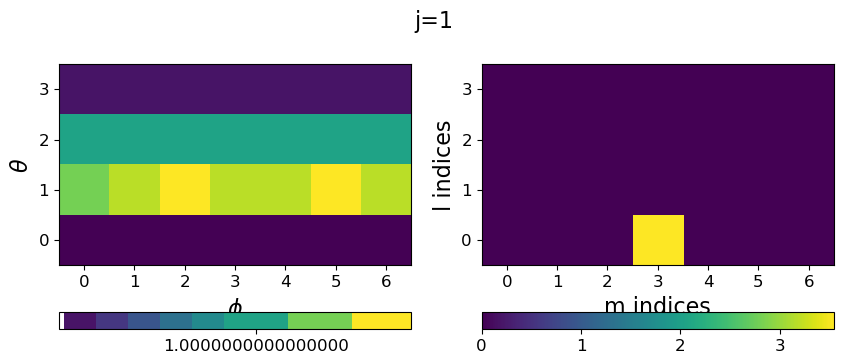

In [5]:
# Plot the Ilm and the map I at resolution j
j = 1
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'{j=}')

im0 = ax0.imshow(np.real(I[j - J_min]), origin='lower')
ax0.set_xlabel(r'$\phi$')
ax0.set_ylabel(r'$\theta$')
fig.colorbar(im0, orientation='horizontal')

im1 = ax1.imshow(np.real(Ilm[j - J_min]), origin='lower')
ax1.set_xlabel('m indices')
ax1.set_ylabel('l indices')
fig.colorbar(im1, orientation='horizontal')

# Make quadrature weights

A priori $quad \simeq \sin\theta d\theta d\phi = \sin\theta \frac{\pi}{L}\frac{2\pi}{(2L-1)}$

In [6]:
### On compare quad et sintheta dtheta dphi
quad = s2fft.quadrature_jax.quad_weights(L, sampling=sampling, nside=nside)
print('\n quad = ', quad)

# Make quad manually
thetas = s2fft.samples.thetas(L, sampling=sampling)
print(f'\n {thetas=}')

dtheta = np.pi / L
dphi = 2*np.pi/ (2*L-1)
quad_bis = np.sin(thetas) * dtheta * dphi

print('\n Ratio = ', quad_bis / quad)


 quad =  [5.28298898e-05 1.85824108e-04 2.99080707e-04 4.23858422e-04
 5.38747453e-04 6.59235804e-04 7.72433821e-04 8.88556842e-04
 9.98322850e-04 1.10934456e-03 1.21433436e-03 1.31936117e-03
 1.41840492e-03 1.51651883e-03 1.60856137e-03 1.69887213e-03
 1.78295582e-03 1.86462780e-03 1.93988944e-03 2.01215865e-03
 2.07783151e-03 2.14001777e-03 2.19543559e-03 2.24695189e-03
 2.29155325e-03 2.33191316e-03 2.36524570e-03 2.39406916e-03
 2.41579312e-03 2.43281090e-03 2.44270182e-03 2.44775866e-03
 2.44570920e-03 2.43876568e-03 2.42478630e-03 2.40591951e-03
 2.38013819e-03 2.34954117e-03 2.31220189e-03 2.27018195e-03
 2.22164220e-03 2.16861808e-03 2.10934510e-03 2.04584308e-03
 1.97640916e-03 1.90305811e-03 1.82413466e-03 1.74166028e-03
 1.65401083e-03 1.56322910e-03 1.46770105e-03 1.36951139e-03
 1.26702610e-03 1.16240494e-03 1.05394497e-03 9.43942284e-04
 8.30531571e-04 7.16278923e-04 5.98937433e-04 4.81711456e-04
 3.61266629e-04 2.42993354e-04 1.17987143e-04 1.23669291e-05]

 thetas=arra

In [11]:
np.max(quad)

Array(0.00244776, dtype=float64)

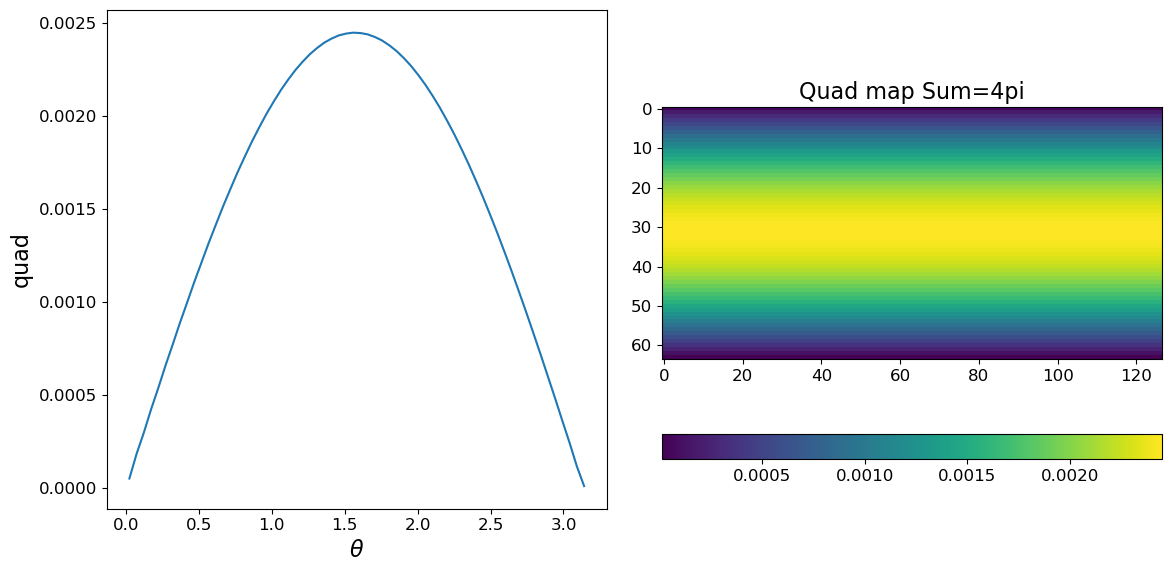

In [29]:
map = np.ones((L, 2*L-1)) * quad[:, None]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.plot(thetas, quad)
ax0.set_xlabel(r'$\theta$')
ax0.set_ylabel('quad')

im1 = ax1.imshow(map)
ax1.set_title('Quad map Sum=4pi')
fig.colorbar(im1, orientation='horizontal')

fig.tight_layout()

In [28]:
# On est content la somme des quad fait 4pi !
print(np.sum(map))
print(4*np.pi)

12.566370614359172
12.566370614359172


# Mean on map or alm space

Average on map space is defined such as
$$\langle f(\omega) \rangle_{\omega} = \frac{1}{4\pi}\int_{\theta=0}^\pi\int_{\phi=0}^{2\pi} f(\omega) d \Omega$$
The surface of the sphere is $4\pi$ (total solid angle), so we divide by $4\pi$ to have a proper average.

The discretization of the integral depends on the pixellisation. Here we consider the MW  isoangle pixellisation such as $\delta\Omega = \sin\theta \delta\theta \delta\varphi$ with $\delta \theta = \text{cst} = \frac{\pi}{N_\theta}$ and $\delta \varphi = \text{cst} = \frac{2\pi}{N_\varphi}$. So we have $$ \langle f(\omega) \rangle_{\omega} = \frac{1}{4\pi}\sum_p (f_p \sin\theta_p )\frac{\pi}{N_\theta}\frac{2\pi}{N_\varphi}.$$


In [232]:
def average_map_MW(I, quad=None):
    """
    <I>_tp = Sum_tp (I * quad) / 4pi
    """
    if quad is None:
        L = I.shape[0]
        quad = s2fft.quadrature_jax.quad_weights(L, sampling='mw')

    avg = np.sum(I * quad[:, None]) / (4*np.pi)
    return avg

def average_with_f00(Ilm, reality=False):
    """
    <I>_tp = I_00 / 2sqrt(pi)
    """
    # Position of the (l=0,m=0) index
    if reality:
        l0, m0 = 0, 0
    else:
        L =  Ilm.shape[0]
        l0, m0 = 0, L - 1
    avg = Ilm[l0, m0] / (2 * np.sqrt(np.pi))
    return avg

In [233]:
for j in range(J_min, J_max + 1):
    Lj = s2wav.utils.shapes.wav_j_bandlimit(L, j, 2.0, multiresolution)
    print(f'\n {j=}')
    print(np.mean(I[j-J_min]))

    print(average_map_MW(I[j-J_min], quad=quads[j-J_min]))
    print(average_with_f00(Ilm[j-J_min], reality=False))
    print(average_map_MW(I[j-J_min], quad=quads[j-J_min]) / average_with_f00(Ilm[j-J_min], reality=False))


 j=0
0.9999999999999996
0.9999999999999997
(1.0000000000000002-6.548161810916603e-34j)
(0.9999999999999994+6.548161810916597e-34j)

 j=1
0.9999999999999996
0.9999999999999997
(1.0000000000000002-6.548161810916603e-34j)
(0.9999999999999994+6.548161810916597e-34j)

 j=2
0.9999999999999997
0.9999999999999997
(1+0j)
(0.9999999999999997+0j)

 j=3
1.0000000000000002
0.9999999999999988
(1+2.031772503979135e-34j)
(0.9999999999999988-2.0317725039791325e-34j)

 j=4
1.0000000000000049
0.9999999999999976
(1-4.897707837373648e-34j)
(0.9999999999999976+4.897707837373636e-34j)

 j=5
1.0000000000000053
0.9999999999999999
(1-2.7887843557781477e-16j)
(0.9999999999999999+2.788784355778147e-16j)

 j=6
1.0000000000000053
0.9999999999999999
(1-2.7887843557781477e-16j)
(0.9999999999999999+2.788784355778147e-16j)


# Variance in map or alm space

$$Var[f(\omega)] = \langle |f(\omega) - \langle f(\omega) \rangle |^2 \rangle_\omega $$

We have seen that the mean in map space is proportional to the $(\ell=0, m=0)$ term of the spherical harmonic transform. Then, substracting the mean in map space is equivalent to remove the first term in alm space.

So in $a_{\ell m}$ space, we can write
$$ Var[f(\omega)] = \frac{1}{4\pi} \sum_{(\ell, m) \neq (0, 0)} |f_{\ell m}|^2 $$

Remark: for this test, the input map must not be 1 everywhere in order to have a non zero variance.

In [183]:
def variance_map_MW(I, quad):
    """
    Var(I) = <|I - <I>_tp|^2>_tp
    """
    # Substract the mean
    I_mean0 = I - average_map_MW(I, quad)
    # Compute the variance
    var = average_map_MW(I_mean0 * np.conj(I_mean0), quad)
    return var

def variance_flm(Ilm, reality):
    """
    Var(I) = Sum_(lm not 00) |Ilm|^2 / 4pi
    """

    # Position of the (l=0,m=0) index
    if reality:
        l0, m0 = 0, 0
    else:
        L =  Ilm.shape[0]
        l0, m0 = 0, L - 1

    # Compute |Ilm|^2 = Ilm x Ilm*
    Ilm_square = Ilm * np.conj(Ilm)

    # Compute the variance
    var = (np.sum(Ilm_square) - Ilm_square[l0, m0]) / (4*np.pi)
    return var

4

 j=0
4

 j=1
8

 j=2
16

 j=3
32

 j=4
64

 j=5
64

 j=6
[Array(0.69492455, dtype=float64), Array(0.69492455, dtype=float64), Array(0.63039624, dtype=float64), Array(0.70258112, dtype=float64), Array(0.59022983, dtype=float64), Array(0.62978933, dtype=float64), Array(0.62978933, dtype=float64)] [Array(0.64804509-3.92643254e-18j, dtype=complex128), Array(0.64804509-3.92643254e-18j, dtype=complex128), Array(0.63675645+1.18315314e-18j, dtype=complex128), Array(0.70146368-2.36722721e-19j, dtype=complex128), Array(0.59168048+7.66197538e-19j, dtype=complex128), Array(0.62995276-4.41688249e-19j, dtype=complex128), Array(0.62995276-4.41688249e-19j, dtype=complex128)]


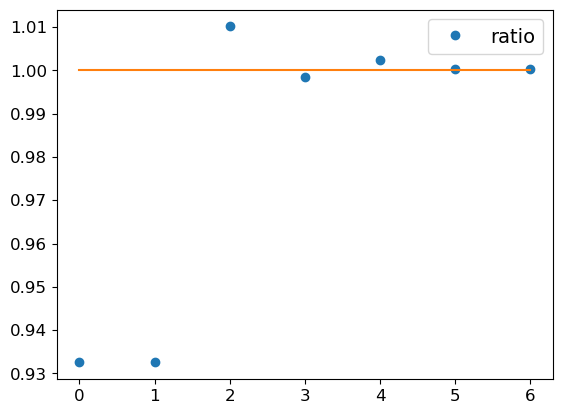

In [187]:
var_map, var_flm = [], []
all_Lj = np.zeros(J)
i = 0
for j in range(J_min, J_max + 1):
    Lj = s2wav.utils.shapes.wav_j_bandlimit(L, j, 2.0, multiresolution)
    all_Lj[i] = Lj
    print(Lj)

    print(f'\n {j=}')

    var_map.append(variance_map_MW(I[j-J_min], quads[j-J_min]))
    var_flm.append(variance_flm(Ilm[j-J_min], reality=False))
    i+=1

print(var_map, var_flm)

allj = np.arange(J_min, J_max + 1)
X = all_Lj * (2*all_Lj -1)

plt.figure()
# plt.plot(var_map, 'o', label='map space')
# plt.plot(var_flm, 'o', label='flm space')
plt.plot(np.array(var_flm)/np.array(var_map), 'o', label='ratio')
plt.plot(np.ones(7))
# plt.plot(X, X+var_map[0], 'k--')
plt.legend()

# Check Parseval

We want to verify the Parseval theorem
$$ \langle |f(\omega)|^2 \rangle_{\omega} = \langle |f_{\ell m}|^2 \rangle_{\ell m}. $$

In [171]:
def average_alm(Ilm):
    avg = np.sum(Ilm) / (4 * np.pi)
    return avg

def scalar_product_map_MW(I1, I2, quad):
    sp = average_map_MW(I1 * np.conj(I2), quad=quad)
    return sp

def scalar_product_flm(Ilm1, Ilm2):
    sp = average_alm(Ilm1 * np.conj(Ilm2))
    return sp

In [189]:
plt.figure()
for j in range(J_min, J_max + 1):
    Lj = s2wav.utils.shapes.wav_j_bandlimit(L, j, 2.0, multiresolution)
    print(f'\n {j=} {Lj=}')

    # Map space
    left_term = scalar_product_map_MW(I[j-J_min], I[j-J_min], quads[j-J_min])

    # flm space
    right_term = scalar_product_flm(Ilm[j-J_min], Ilm[j-J_min])

    print(left_term)
    print(right_term)


    print(left_term/right_term)



 j=0 Lj=4
0.7411632781800181
(0.6942838184881116-3.926432543664109e-18j)
(1.0675220398971594+6.037233141424101e-18j)

 j=1 Lj=4
0.7411632781800181
(0.6942838184881116-3.926432543664109e-18j)
(1.0675220398971594+6.037233141424101e-18j)

 j=2 Lj=8
0.6358642135937734
(0.6422244222779817+1.183153139635468e-18j)
(0.9900965947983595-1.824028881559752e-18j)

 j=3 Lj=16
0.7027932799180541
(0.7016758351609552-2.36722720598896e-19j)
(1.0015925370393333+3.3790491052768537e-19j)

 j=4 Lj=32
0.5917279538472553
(0.5931786109976966+7.661975384784568e-19j)
(0.9975544344931767-1.288522104533383e-18j)

 j=5 Lj=64
0.63033046716834
(0.6304938939446628-4.416882488798524e-19j)
(0.9997407956240458+7.003616777162496e-19j)

 j=6 Lj=64
0.63033046716834
(0.6304938939446628-4.416882488798524e-19j)
(0.9997407956240458+7.003616777162496e-19j)


<Figure size 640x480 with 0 Axes>

# Check P00 computation

$P_{00} = \langle |W|^2\rangle_{\theta\phi} = \langle M_{\ell m}^2\rangle_{\ell m}$

et on calcule aussi $S_1^2/ P_{00}$.

In [235]:
sampling = "mw"
multiresolution = True
reality = True

L = 16
N = 2
J_min = 1
nside = None

J_max = s2wav.utils.shapes.j_max(L)
J = J_max -J_min + 1  # Number of scale used
print(J_max, J)

# ## One everywhere
# I0 = np.ones((L, 2 * L - 1)).astype(np.float64)
# Ilm = s2fft.forward_jax(I0, L, sampling=sampling, nside=nside)
## I.append(s2fft.inverse_jax(Ilm, L, reality=reality))

# Gaussian noise
np.random.seed(2)
I0 = np.random.randn(L, 2 * L - 1).astype(np.float64)
Ilm = s2fft.forward_jax(I0, L, sampling=sampling, nside=nside)
# I.append(s2fft.inverse_jax(Ilm, L, reality=reality))

# Planet
# I0, Ilm = sphlib.make_planet(L, 'venus', normalize=False, reality=False)
#I.append(s2fft.inverse_jax(Ilm, L, reality=False))

4 4


(5, 16, 31)


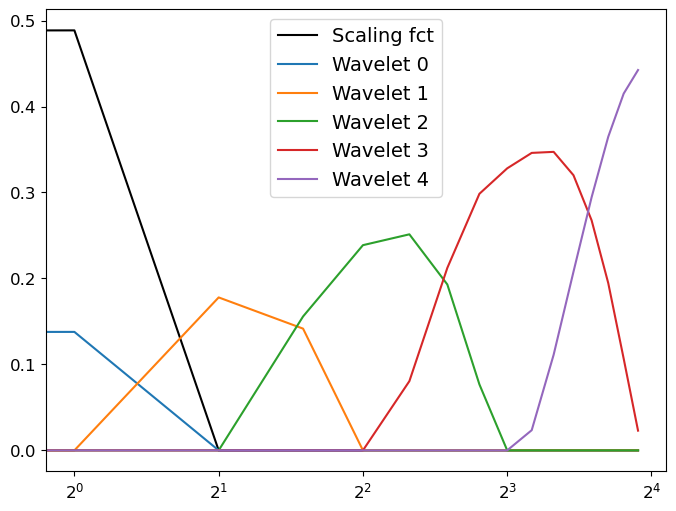

In [236]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=False, m=L-2)

filters = filters[0]
print(filters.shape)

In [237]:
import jax.numpy as jnp
import jax.lax as lax

S1, P001, P002 = [], [], []

quads = []
for j in range(J_min, J_max + 1):
    Lj = s2wav.utils.shapes.wav_j_bandlimit(L, j, 2.0, multiresolution)
    print('Lj', Lj)
    quads.append(s2fft.quadrature_jax.quad_weights(Lj, sampling, nside))  # [J][Lj]
print('quad', len(quads), quads[0].shape, quads[1].shape)

### Perform first (full-scale) wavelet transform W_j2 = I * Psi_j2
W = s2wav.flm_to_analysis(
    Ilm,
    L,
    N,
    J_min,
    sampling=sampling,
    nside=nside,
    reality=reality,
    multiresolution=multiresolution,
    filters=filters,
    precomps=None
)  # [J2][Norient2, Nthetaj2, Nphij2]=[J][2N-1, Lj, 2Lj-1]
print('W', len(W), W[0].shape, W[-1].shape)

for j2 in range(J_min, J_max + 1):
    print(f'\n {j2=}')
    # Subsampling: the resolution in the plane (l, m) is adapted at each scale j2
    Lj2 = s2wav.utils.shapes.wav_j_bandlimit(L, j2, 2.0, multiresolution)  # Band limit at resolution j2
    print(f'{Lj2=}')

    def modulus_step_for_j(n, args):
        """
        Compute M_lm = |W|_lm for one orientation.
        This function is re-defined at each step j2.
        """
        M_lm = args
        M_lm = M_lm.at[n].add(
            s2fft.forward_jax(
                jnp.abs(W[j2 - J_min][n]),
                Lj2,
                0,
                sampling=sampling,
                nside=nside,
                reality=reality,
            )
        )
        return M_lm  # [Lj2, Mj2] = [Lj2, 2Lj2-1]

    ### Compute M_lm for all orientations
    # Initialization
    M_lm_j2 = jnp.zeros((2 * N - 1, Lj2, 2 * Lj2 - 1), dtype=jnp.complex128)  # [Norient2, Lj2, Mj2]
    # Loop on orientations
    M_lm_j2 = lax.fori_loop(0, 2 * N - 1, modulus_step_for_j, M_lm_j2)  # [Norient2, Lj2, Mj2]

    ### Compute S1_j2 = < M_lm >_j2
    # Take the value at (l=0, m=0) which corresponds to indices (0, Lj2-1)
    # Todo!! A priori ok
    s1 = M_lm_j2[:, 0, Lj2 - 1] / (2 * jnp.sqrt(jnp.pi))  # [Norient2]
    S1.append(s1)

    ### Compute P00_j2 = < |M_lm|^2 >_j2
    # Average over lm (Parseval)
    # Todo!!
    p001 = jnp.sum((jnp.abs(W[j2 - J_min]) ** 2) * quads[j2-J_min][None, :, None], axis=(-1, -2)) / (4 * np.pi)
    print('P00 1st way', p001)

    p002 = jnp.sum(jnp.abs(M_lm_j2)** 2, axis=(-1, -2)) / (4 * np.pi)  # [Norient2]
    print('P00 2nd way', jnp.real(p002))
    print('Ratio', p001/jnp.real(p002))

    P001.append(p001)
    P002.append(p002)

S1 = np.array(S1)
P001 = np.array(P001)
P002 = np.array(P002)

Lj 4
Lj 8
Lj 16
Lj 16
quad 4 (4,) (8,)
W 4 (3, 4, 7) (3, 16, 31)

 j2=1
Lj2=4
P00 1st way [0.0086859  0.00539822 0.00484686]
P00 2nd way [0.00840894 0.00524997 0.00454823]
Ratio [1.03293653 1.02823845 1.06566023]

 j2=2
Lj2=8
P00 1st way [0.02056827 0.02180431 0.01889887]
P00 2nd way [0.01867388 0.02023785 0.01812888]
Ratio [1.10144594 1.07740209 1.04247305]

 j2=3
Lj2=16
P00 1st way [0.04790041 0.03751783 0.03882138]
P00 2nd way [0.04257459 0.0336905  0.03545092]
Ratio [1.12509404 1.11360245 1.09507381]

 j2=4
Lj2=16
P00 1st way [0.04631954 0.04270267 0.03784745]
P00 2nd way [0.04270017 0.03764608 0.03340733]
Ratio [1.08476254 1.13431927 1.13290886]


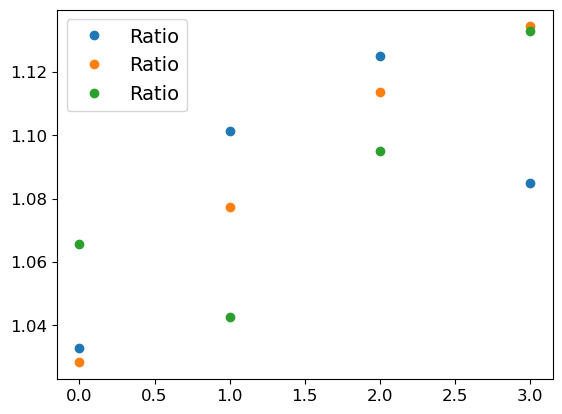

In [238]:
plt.figure()
plt.plot(P001 / P002, 'o', label='Ratio')
plt.legend()

[[0.72013135+0.j 0.74546804+0.j 0.70262311+0.j]
 [0.72021397+0.j 0.66875245+0.j 0.66546203+0.j]
 [0.61634216+0.j 0.59014022+0.j 0.65041102+0.j]
 [0.64547009+0.j 0.62949771+0.j 0.64706145+0.j]]
[[0.74384998+0.j 0.7665189 +0.j 0.7487575 +0.j]
 [0.79327675+0.j 0.72051529+0.j 0.69372623+0.j]
 [0.69344289+0.j 0.6571816 +0.j 0.71224807+0.j]
 [0.70018178+0.j 0.71405138+0.j 0.73306165+0.j]]


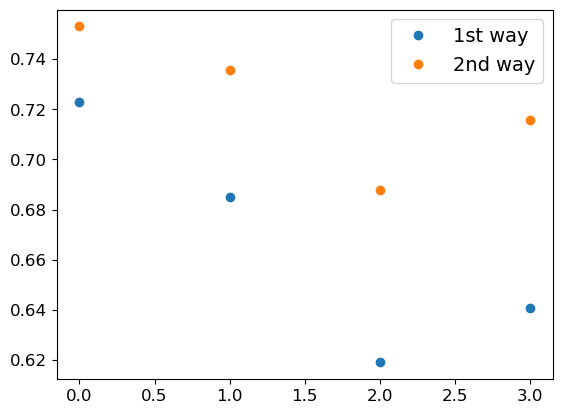

In [239]:
print(S1**2 / P001)
print(S1**2 / P002)

plt.figure()
plt.plot(np.mean(S1**2 / P001, axis=1), 'o', label='1st way')
plt.plot(np.mean(S1**2 / P002, axis=1), 'o', label='2nd way')
plt.legend()